# Dataset 과 Dataloader

- 간단한 예제에서는 모든 데이터를 모아서 학습용으로 사용했지만, 데이터가 늘어나거나 신경망 계층의 증가 또는 파라미터가 늘어나면 전체 데이터를 메모리에서 처리하기가 어려워진다.
- 이 문제를 해결하기 위해 데이터의 일부 미니배치만 사용하는 방법을 알아본다

파이토치에는 Dataset과 Dataloder라는 기능이 있어서 미니 배치 학습이나 데이터 셔플, 병렬 처리 등을 간단하게 할 수 있다.

TensorDataset은 Dataset을 상속한 클래스로 학습 데이터 X와 레이블 Y를 묶어 놓은 컨테이너이다.

TensorDataset을 DataLoader에 전달하면 for 루프에서 데이터의 일부만 간단하게 추출할 수 있다.

TensorDataset에는 텐서만 전달할 수 있으며, Variable은 전달할 수 없으니 주의하자!


In [13]:
import torch
from torch import nn, optim
from sklearn.datasets import load_digits
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary
import matplotlib.pyplot as plt

digits = load_digits()

X = digits.data
Y = digits.target


# Numpy의 ndarray를 파이토치 텐서로 변환
X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.int64)

# 데이터셋을 작성
ds = TensorDataset(X, Y)

# 데이터 순서를 섞어서 64개씩 데이터를 반환하는 Dataloader
loader = DataLoader(ds, batch_size=64, shuffle=True)

model = nn.Sequential(
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 10)
)

lossfunc = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

loss = []
for epoch in range(10):
    runningLoss = 0.0
    for batchX, batchY in loader:
        optimizer.zero_grad()
        # batchX, batchY는 64개씩 받습니다.
        yPred = model(batchX)
        loss = lossfunc(yPred, batchY)
        loss.backward()
        optimizer.step()
        runningLoss += loss.item()
    losses.append(runningLoss)

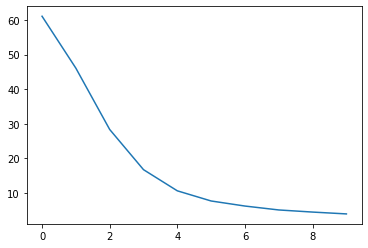

In [14]:
plt.plot(losses)

# 사용자 정의 DATASET, DATALOADER, TRANSFORMS 작성하기

딥러닝, 머신러닝 문제를 푸는 과정에서 데이터를 준비하는데 많은 노력이 필요하다

PyTorch는 데이터를 불러오는 과정을 쉽게 해주고, 또 잘 사용한다면 코드의 가독성도 보다 높여줄 수 있는 도구들을 제공!

이번 Tutorial에서 일반적이지 않은 데이터셋으로부터 데이터를 읽어오고 전처리하고 증가하는 방법을 알아본다.

이번 튜토리얼을 시작하기 전에 다음 의 패키지를 설치해야한다.

  * scikit-image : 이미지와 io 변환하기 위해

  * pandas : csv 파싱 쉽게하기 위해
  
설치 방법은..

> conda install -c anaconda scikit-image

> conda install -c anaconda pandas

In [15]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()

위의 코드를 실행했을 때 오류가 나지 않는다면 scukut-image와 pandas 패키지가 제대로 깔린 것이다!

In [45]:
landmarks_frame = pd.read_csv('D:/faces/faces/face_landmarks.csv')
n = 64
# n이 사진의 번지 수 n의 변화에 따라 다른 사람의 사진이 나온다.

img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: matt-mathes.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[ 85. 152.]
 [ 83. 173.]
 [ 83. 195.]
 [ 85. 217.]]


이미지와 랜드마크(landmark)를 보여주는 간단한 함수를 작성해보고, 실제로 적용해보자!

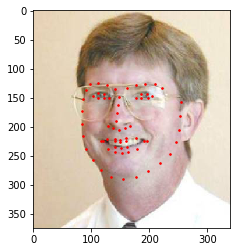

In [46]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    """ 랜드마크(landmark)와 이미지 출력. """
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # 갱신이 되도록 잠시 멈춥니다.

plt.figure()
show_landmarks(io.imread(os.path.join('D:/faces/faces/', img_name)),
               landmarks)
plt.show()

# Dataset Class

torch.utils.data.Dataset은 데이터셋을 나타내는 추상클래스, custom dataset은 Dataset을 상속 받고 다음과 같은 방법으로 재정의해야한다.

 * __len__을 재정의하여 len(dataset)으로 데이터셋의 사이즈를 리턴한다.

 * __getitem__를 재정의하면, dataset[i]과 같이 인덱싱하여 i번째 샘플을 사용할 수 있다.

face landmarks 데이터셋을 사용하기 위한 데이터셋 클래스를 만들어보자. __init__ 에서 csv를 읽어야 하지만, __getitem__ 를 사용하여 이미지를 읽어들인다.

이것은 모든 이미지가 메모리에 한번에 저장되지는 않지만, 이미지를 필요에 따라 읽어오기 때문에 메모리 효율적이다.

- Args:
            csv_file (string): 주석을 포함하고있는 csv파일의 경로
            root_dir (string): 모든 이미지를 포함하는 폴더
            transform (callable, optional):샘플에 적용하기위한 선택적 변환

In [48]:
class FaceLandmarksDataset(Dataset):
    
    def __init__(self, csv_file, root_dir, transform=None):
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.landmarks_frame)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

0 (324, 215, 3) (68, 2)


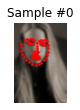

1 (500, 333, 3) (68, 2)


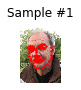

2 (250, 258, 3) (68, 2)


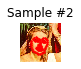

3 (434, 290, 3) (68, 2)


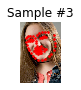

4 (828, 630, 3) (68, 2)


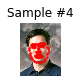

5 (402, 500, 3) (68, 2)


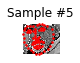

In [57]:
face_dataset = FaceLandmarksDataset(csv_file='D:/faces/faces/face_landmarks.csv',root_dir='D:/faces/faces/')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 6, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 5:
        plt.show()
        break

# if문 안의 i값을 조절하여 plot의 개수를 조절할 수 있다.

위에서 언급한 바와 같이, __len__과 __getitem__을 정의하고, 옵션으로 transform할 수 있게 했다. 이 클래스를 인스턴트화하고 데이터 샘플을 반복한다. 처음 4개의 샘플의 크기를 프린트하고, 랜드마크를 표시한다. 

## Transforms

- 위의 코드와 결과화면에서 볼 수 있었던 한가지 문제점은 샘플들이 다 같은 사이즈가 아니라는 것이다. 대부분의 neural networks 는 고정된 크기의 이미지라고 가정한다. 그러므로 우리는 신경망에 주기전에 처리할 과정을 작성해야한다

- 즉, 고정된 사이즈의 이미지를 필요로하기 때문에 전처리(Prepocessing) 코드를 작성해야 한다.

3가지의 transforms 을 만들어 본다: 

- Rescale: 이미지의 크기를 조절한다. 
- RandomCrop: 이미지를 무작위로 자른다. 이것을 data augmentation이라 한다.

- ToTensor: numpy 이미지에서 torch 이미지로 변경한다.

data aurmentation은 이미지 전처리 과정 중 가장 중요한 것으로 원본 이미지를 신경망 학습에 활용할 수 있도록 인위적 변화를 주는 것이다.

간단한 함수대신에 호출 할 수 있는 클래스로 작성한다. 이렇게 하면, 클래스가 호출될 때마다 Transform의 매개 변수가 전달되지 않아도 된다.

그러기 위해서는 call함수를 구현해야한다.

     주어진 사이즈로 샘플크기를 조정합니다.

    변수:
            output_size(tuple or int) : 원하는 사이즈 값
            tuple인 경우 해당 tuple(output_size)이 결과물(output)의 크기가 되고,
            int라면 비율을 유지하면서, 길이가 작은 쪽이 output_size가 됩니다.

In [74]:
class Rescale(object):
        
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
        
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size* w / h
        else:
            new_h, new_w = self.output_size
        
        new_h, new_w = int(new_h), int(new_w)
        
        img = transform.resize(image, (new_h, new_w))

        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}

샘플에서 이미지를 랜덤으로 크롭한다. 

    변수:
        output_size (tuple or int): 줄이고자 하는 크기. int이면 정사각형으로 출력된다.

In [82]:
class RandomCrop(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = ouput_size
    
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        
        landmarks = landmarks - [left, top]
        
        return {'image': image, 'landmarks': landmarks}
    

In [83]:
class ToTensor(object):
    """numpy array를 tensor(torch)로 변환 시켜줍니다."""
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

## Compose transforms

이미지의 가로 세로 중 짧을 쪽을 265로 Rescale하고 224크기의 정사각형으로 RandomCrop하고자 한다.

* Rescale과 RandomCrop변환을 조합해야한다. 

torchvision.transforms.Compose는 이러한 작업을 호출 클래스이다. 

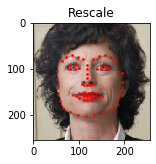

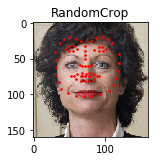

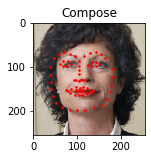

In [86]:
scale = Rescale(256)  #리스케일
crop = RandomCrop(128)   #랜덤크롭
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# 위의 transform을 샘플에 적용합니다. 
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

## Iterating through the dataset(데이터셋을 이용한 반복작업)

전이(transform)를 적용한 dataset을 만들기위해서 만들었던것을 다 집어 넣어 보자.

요약하자면, 데이터셋은 다음과 같이 샘플링 된다.

* 이미지를 파일로부터 즉석으로 읽어온다. 

* 읽어온 이미지를 변환(Transform)한다. 

* 변환이 랜덤으로 이루어지기때문에 샘플링 데이터는  향상된다. 


In [87]:
transformed_dataset = FaceLandmarksDataset(csv_file='D:/faces/faces/face_landmarks.csv',
                                           root_dir='D:/faces/faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    
    print(i, sample['image'].size(), sample['landmarks'].size())
    
    if i == 4:
        break

0 torch.Size([3, 385, 256]) torch.Size([68, 2])
1 torch.Size([3, 384, 256]) torch.Size([68, 2])
2 torch.Size([3, 256, 264]) torch.Size([68, 2])
3 torch.Size([3, 383, 256]) torch.Size([68, 2])
4 torch.Size([3, 336, 256]) torch.Size([68, 2])


그러나, 데이터 상에서 반복하는 for 문은 많은 특징(features)를 놓칠 수 있다.
- 데이터를 묶는 과정(batch)

- 데이터를 섞는 과정(shuffle)

- 병렬처리 과정에서 multiprocessing 을 사용할때 데이터를 불러오는 것

torch.utils.data.DataLoader은 이러한 모든 기능을 제공하는 반복기다. 흥미로운 파라미터는 collate_fn 이다. collate_fn을 이용하면 샘플을 얼마나 정확하게 배치해야하는지를 설정할 수 있다. 

0 torch.Size([1, 3, 392, 256]) torch.Size([1, 68, 2])
1 torch.Size([1, 3, 256, 342]) torch.Size([1, 68, 2])


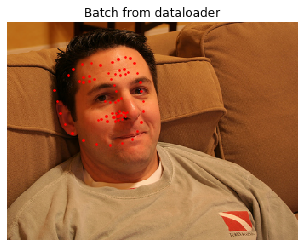

In [109]:
dataloader = DataLoader(transformed_dataset, batch_size=1,
                        shuffle=True, num_workers=0)

# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 1:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

원래 
        - dataloader = DataLoader(transformed_dataset, batch_size=1,
                                shuffle=True, num_workers=0)
                                
1. 이 부분에서 batch_size = 4, num_workers = 4 였으나 내가 사용한 pc의 경우 듀얼이 아니기 때문에 num_workers를 0으로 설정해야만 Broken Pipe 오류가 뜨지 않는다.

2. 그리고 batch_size를 1로 조절한 이유는 기본적으로 각 배치는 단일 텐서 (매트릭스)이고 pytorch는 배치의 모든 이미지가 동일한 크기여야 한다.

* 즉, 2D 행렬이있는 경우 2 행에 7 열이 있으면 1 행에 5 열을 가질 수 없습니다. 행렬의 모든 행은 같은 수의 열을 가져야 한다. pytorch를 사용하여 실제로 크기를 얻으려면 batch_size를 1로 설정하면 된다.

batch_size에 대한 아이디어는 https://medium.com/@yvanscher/pytorch-tip-yielding-image-sizes-6a776eb4115b 이 곳을 참조하였다.